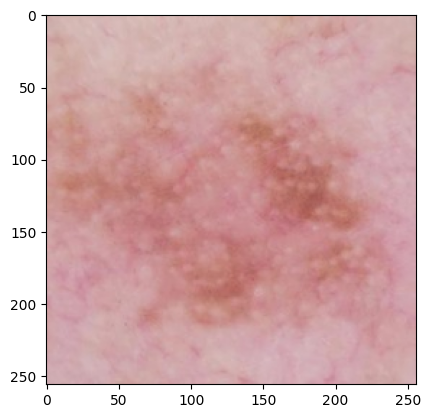

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0027859.jpg"
img = Image.open(img_path)
plt.imshow(img)
plt.show()


In [2]:
import os

image_dir = '/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image'
image_files = os.listdir(image_dir)
print(image_files[:5])


['ISIC_0030912.jpg', 'ISIC_0035342.jpg', 'ISIC_0028933.jpg', 'ISIC_0030585.jpg', 'ISIC_0033697.jpg']


In [3]:
import pandas as pd

metadata = pd.read_csv('/kaggle/input/isic-2018-jpg-256x256-resized/train-metadata.csv')
print(metadata.head())


   Unnamed: 0       isic_id   patient_id  target
0           0  ISIC_0028498  HAM_0000000     0.0
1           1  ISIC_0027859  HAM_0000001     0.0
2           2  ISIC_0034246  HAM_0000002     1.0
3           3  ISIC_0027886  HAM_0000003     0.0
4           4  ISIC_0024645  HAM_0000004     0.0


In [4]:
import os
import pandas as pd

# Paths
image_folder = '/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image'
metadata_file = '/kaggle/input/isic-2018-jpg-256x256-resized/train-metadata.csv'

# Get list of image filenames (excluding extensions if needed)
image_files = [os.path.splitext(f)[0] for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Load metadata
metadata = pd.read_csv(metadata_file)

# Check missing files
missing_files = set(metadata['isic_id']) - set(image_files)
#print(f"Missing files: {missing_files}")


In [5]:
# Filter metadata to include only available images
filtered_metadata = metadata[metadata['isic_id'].isin(image_files)]

# Check the new length
print(f"Filtered metadata size: {len(filtered_metadata)}")


Filtered metadata size: 7496


In [6]:
# Filter out images without labels
image_files_with_labels = set(filtered_metadata['isic_id'])
valid_images = [f for f in os.listdir(image_folder) if os.path.splitext(f)[0] in image_files_with_labels]


In [7]:
# Ensure the counts match
assert len(filtered_metadata) == len(valid_images), "Mismatch between filtered labels and valid images!"


In [8]:
# Load filtered metadata
image_labels = dict(zip(filtered_metadata['isic_id'], filtered_metadata['target']))


In [14]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader


class CustomImageDataset(Dataset):
    def __init__(self, image_folder, image_labels, transform=None):
        self.image_folder = image_folder
        self.image_labels = image_labels
        self.transform = transform
        self.image_files = list(image_labels.keys())  # Filtered image filenames

    def __len__(self):
        return len(self.image_files)
 
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label = self.image_labels[img_name]
        
        # Construct the full path to the image file
        img_path = os.path.join(self.image_folder, img_name + '.jpg')  
        
        # Open the image
        image = Image.open(img_path).convert("RGB")  
        
        # Apply transformations, if any
        if self.transform:
            image = self.transform(image)
        
        return image, label




transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.5)
])



# Create dataset
dataset = CustomImageDataset(
    image_folder=image_folder,
    image_labels=image_labels,
    transform=transform
)

# Create DataLoader
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



In [15]:
from torch.utils.data import DataLoader, random_split

dataset_size = len(dataset)

# Split sizes for train and test sets 
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify split sizes
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Train size: 5996, Test size: 1500


In [16]:
for images, labels in train_loader:
    print(images.shape, labels)
    break


torch.Size([32, 3, 128, 128]) tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       dtype=torch.float64)


In [17]:
# create the model
import torch 
import torch.nn as nn
from torch.optim import Adam


# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3),           
            nn.ReLU(),                    
            nn.Conv2d(32, 64, 3),          
            nn.ReLU(),                     
            nn.Conv2d(64, 128, 3),         
            nn.ReLU(),                     
            nn.Flatten(),                  
            nn.Linear(128 * 122 * 122, 10),
            nn.ReLU(),                     
            nn.Linear(10, 2)               
        )
    
    def forward(self, x):
        return self.model(x)




In [18]:

model = MyModel()
Criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epoch = 20


for epoch in range(num_epoch):
    running_loss = 0.0  # Initialize running_loss for each epoch
    for images, labels in train_loader:
        
        # Ensure labels are of type LongTensor
        labels = labels.long()

        # Forward pass
        output = model(images)
        loss = Criterion(output, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print loss for the epoch
    print(f'Epoch: {epoch + 1}/{num_epoch}, Loss: {running_loss / len(train_loader)}')

print("Training Complete")



Epoch: 1/20, Loss: 0.3285984788486298
Epoch: 2/20, Loss: 0.2632501719400604
Epoch: 3/20, Loss: 0.26014753147721925
Epoch: 4/20, Loss: 0.2588548817017928
Epoch: 5/20, Loss: 0.25548084977855706
Epoch: 6/20, Loss: 0.2564042454704325
Epoch: 7/20, Loss: 0.25252498916171967
Epoch: 8/20, Loss: 0.24960204322842208
Epoch: 9/20, Loss: 0.25027479990286394
Epoch: 10/20, Loss: 0.24233194188948007
Epoch: 11/20, Loss: 0.24457150000206967
Epoch: 12/20, Loss: 0.23709869967337618
Epoch: 13/20, Loss: 0.24179399252294542
Epoch: 14/20, Loss: 0.23815379313569754
Epoch: 15/20, Loss: 0.2329395474033787
Epoch: 16/20, Loss: 0.23586465913723123
Epoch: 17/20, Loss: 0.23309646031640946
Epoch: 18/20, Loss: 0.23049514736742416
Epoch: 19/20, Loss: 0.2249186291418811
Epoch: 20/20, Loss: 0.219609211407047
Training Complete


In [19]:
# Evaluating the model
model.eval()  # Set the model to evaluation mode

# Disable gradient calculation
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:

        # Forward pass
        output = model(images)

        # Get predictions
        _, predicted = torch.max(output, 1)  # Get the index of the max log-probability

        # Update totals
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correctly predicted labels

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')


Accuracy of the model on the test data: 90.13%


In [20]:
# save the complete model 

torch.save(model, "model_complete.pth")
print("Complete model saved successfully.")


Complete model saved successfully.


In [21]:
# Save model's state_dict
torch.save(model.state_dict(), "model.pth")
print("Model saved successfully.")


Model saved successfully.
